# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

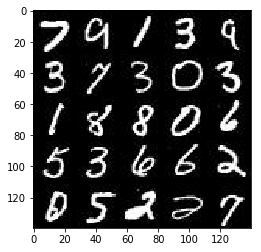

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

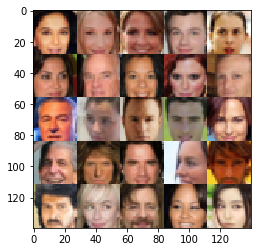

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input_images = tf.placeholder(tf.float32, shape = (None, image_width, image_height, image_channels))
    z_input = tf.placeholder(tf.float32, shape = (None, z_dim))
    learning_rate = tf.placeholder(tf.float32)

    return real_input_images, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Leaky RELU Activation Function

Implements the Leaky RELU activation function used in the Discriminator and Generator. 

Takes in a tensor, x.

For x >= 0, gives a linear activation, x, with gradient 1
For x < 0, gives a slow linear activation, alpha * x, where alpha is a small constant, set here by default to 0.2.
For negative x then, the gradient is alpha.

Returns: the activation

In [9]:
def leaky_RELU (x):
    alpha = 0.2
    return tf.maximum(alpha * x, x)

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [10]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope("discriminator", reuse=reuse):
        alpha = 0.2
        
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = leaky_RELU(x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = leaky_RELU(bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = leaky_RELU(bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [11]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    alpha = 0.2 
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = leaky_RELU(x1)
        # 4x4x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_RELU(x2)
        # 7x7x128 now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = leaky_RELU(x3)
        # 14x14x64 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28xout_channel_dim now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [13]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels= (1 - smooth) * tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [16]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
      # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    #d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    #g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):  
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)


    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [23]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    sample_z = np.random.uniform(-1, 1, size=(50, z_dim))

    samples, losses = [], []
    steps = 0
    
    print_every = 10
    show_every = 100
    
    #build graph
    
    real_input, z_input, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
                
    output_channel_dim = data_shape[3]
                
    d_loss, g_loss = model_loss(real_input, z_input, output_channel_dim)
                
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
                
    #train
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                #get_batches returns images that are scaled to -0.5, 0.5. Want -1, 1.
                batch_images *= 2
                
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={real_input: batch_images, z_input: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={z_input: batch_z, learn_rate : learning_rate, real_input: batch_images})
                

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({z_input: batch_z, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, z_input, output_channel_dim, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.3880... Generator Loss: 19.9280
Epoch 1/2... Discriminator Loss: 1.5871... Generator Loss: 9.2929
Epoch 1/2... Discriminator Loss: 6.4668... Generator Loss: 0.0086
Epoch 1/2... Discriminator Loss: 1.4019... Generator Loss: 4.1692
Epoch 1/2... Discriminator Loss: 0.6719... Generator Loss: 2.4426
Epoch 1/2... Discriminator Loss: 0.5391... Generator Loss: 2.1997
Epoch 1/2... Discriminator Loss: 0.6606... Generator Loss: 1.4812
Epoch 1/2... Discriminator Loss: 0.5401... Generator Loss: 2.4805
Epoch 1/2... Discriminator Loss: 0.5675... Generator Loss: 2.2228
Epoch 1/2... Discriminator Loss: 0.7236... Generator Loss: 1.3718


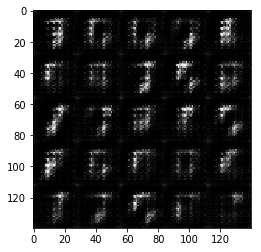

Epoch 1/2... Discriminator Loss: 0.8894... Generator Loss: 1.5794
Epoch 1/2... Discriminator Loss: 0.6432... Generator Loss: 2.0395
Epoch 1/2... Discriminator Loss: 1.3757... Generator Loss: 0.5450
Epoch 1/2... Discriminator Loss: 1.0569... Generator Loss: 2.8954
Epoch 1/2... Discriminator Loss: 0.8222... Generator Loss: 1.5943
Epoch 1/2... Discriminator Loss: 0.8750... Generator Loss: 1.2668
Epoch 1/2... Discriminator Loss: 0.6848... Generator Loss: 2.0635
Epoch 1/2... Discriminator Loss: 1.4294... Generator Loss: 0.5395
Epoch 1/2... Discriminator Loss: 1.2397... Generator Loss: 2.8770
Epoch 1/2... Discriminator Loss: 1.3958... Generator Loss: 0.5750


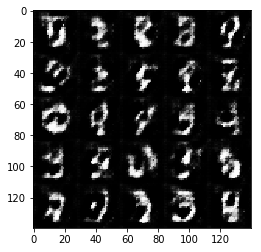

Epoch 1/2... Discriminator Loss: 0.6843... Generator Loss: 1.8356
Epoch 1/2... Discriminator Loss: 0.9545... Generator Loss: 2.4073
Epoch 1/2... Discriminator Loss: 1.1688... Generator Loss: 0.6803
Epoch 2/2... Discriminator Loss: 1.7918... Generator Loss: 3.3669
Epoch 2/2... Discriminator Loss: 1.2675... Generator Loss: 2.6287
Epoch 2/2... Discriminator Loss: 1.0211... Generator Loss: 1.3044
Epoch 2/2... Discriminator Loss: 1.0556... Generator Loss: 0.9210
Epoch 2/2... Discriminator Loss: 1.0763... Generator Loss: 1.9589
Epoch 2/2... Discriminator Loss: 1.3126... Generator Loss: 0.6640
Epoch 2/2... Discriminator Loss: 0.9670... Generator Loss: 0.9842


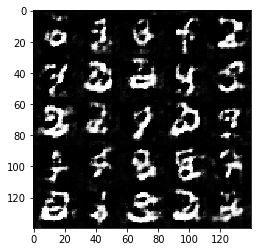

Epoch 2/2... Discriminator Loss: 1.4296... Generator Loss: 0.5742
Epoch 2/2... Discriminator Loss: 0.7874... Generator Loss: 1.6107
Epoch 2/2... Discriminator Loss: 0.8810... Generator Loss: 2.0641
Epoch 2/2... Discriminator Loss: 0.9517... Generator Loss: 1.8369
Epoch 2/2... Discriminator Loss: 1.0086... Generator Loss: 1.6536
Epoch 2/2... Discriminator Loss: 0.9281... Generator Loss: 1.5566
Epoch 2/2... Discriminator Loss: 0.9403... Generator Loss: 1.0654
Epoch 2/2... Discriminator Loss: 1.1649... Generator Loss: 2.5431
Epoch 2/2... Discriminator Loss: 0.9283... Generator Loss: 1.1382
Epoch 2/2... Discriminator Loss: 0.9679... Generator Loss: 0.9723


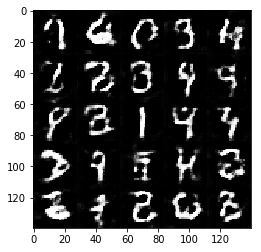

Epoch 2/2... Discriminator Loss: 1.0282... Generator Loss: 2.3359
Epoch 2/2... Discriminator Loss: 0.9385... Generator Loss: 1.5490
Epoch 2/2... Discriminator Loss: 1.0601... Generator Loss: 0.8250
Epoch 2/2... Discriminator Loss: 1.0925... Generator Loss: 0.7959
Epoch 2/2... Discriminator Loss: 0.9265... Generator Loss: 1.2990
Epoch 2/2... Discriminator Loss: 0.9917... Generator Loss: 1.5797


In [24]:
batch_size = 256
z_dim = 200
learning_rate = 0.0008
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.8505... Generator Loss: 16.5463
Epoch 1/1... Discriminator Loss: 0.4891... Generator Loss: 5.1091
Epoch 1/1... Discriminator Loss: 0.6816... Generator Loss: 2.1313
Epoch 1/1... Discriminator Loss: 0.5852... Generator Loss: 2.2683
Epoch 1/1... Discriminator Loss: 0.7471... Generator Loss: 2.1131
Epoch 1/1... Discriminator Loss: 0.6754... Generator Loss: 1.9315
Epoch 1/1... Discriminator Loss: 0.7280... Generator Loss: 1.9268
Epoch 1/1... Discriminator Loss: 1.1522... Generator Loss: 0.7983
Epoch 1/1... Discriminator Loss: 0.9496... Generator Loss: 5.1835
Epoch 1/1... Discriminator Loss: 0.8725... Generator Loss: 1.4174


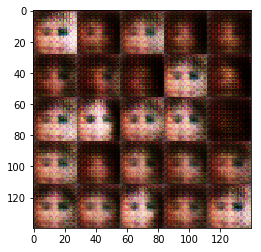

Epoch 1/1... Discriminator Loss: 0.9686... Generator Loss: 1.3145
Epoch 1/1... Discriminator Loss: 0.6676... Generator Loss: 2.8020
Epoch 1/1... Discriminator Loss: 0.9581... Generator Loss: 1.0876
Epoch 1/1... Discriminator Loss: 0.5562... Generator Loss: 2.9446
Epoch 1/1... Discriminator Loss: 1.1967... Generator Loss: 0.8574
Epoch 1/1... Discriminator Loss: 0.7750... Generator Loss: 1.3180
Epoch 1/1... Discriminator Loss: 1.5436... Generator Loss: 4.3522
Epoch 1/1... Discriminator Loss: 1.2073... Generator Loss: 0.9111
Epoch 1/1... Discriminator Loss: 1.1267... Generator Loss: 0.9961
Epoch 1/1... Discriminator Loss: 0.8395... Generator Loss: 1.4832


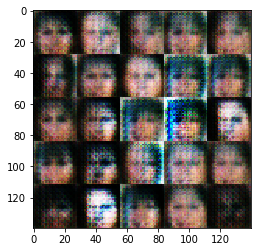

Epoch 1/1... Discriminator Loss: 1.4499... Generator Loss: 0.5461
Epoch 1/1... Discriminator Loss: 2.1099... Generator Loss: 0.2314
Epoch 1/1... Discriminator Loss: 0.9221... Generator Loss: 1.4081
Epoch 1/1... Discriminator Loss: 0.9362... Generator Loss: 1.5693
Epoch 1/1... Discriminator Loss: 1.0556... Generator Loss: 1.1289
Epoch 1/1... Discriminator Loss: 1.2295... Generator Loss: 0.7391
Epoch 1/1... Discriminator Loss: 0.9496... Generator Loss: 1.4131
Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 2.7099
Epoch 1/1... Discriminator Loss: 0.8945... Generator Loss: 1.3102
Epoch 1/1... Discriminator Loss: 1.0472... Generator Loss: 2.2476


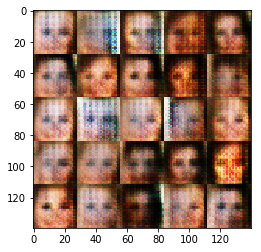

Epoch 1/1... Discriminator Loss: 0.9753... Generator Loss: 1.5418
Epoch 1/1... Discriminator Loss: 0.7460... Generator Loss: 1.5046
Epoch 1/1... Discriminator Loss: 0.8336... Generator Loss: 1.4112
Epoch 1/1... Discriminator Loss: 0.7945... Generator Loss: 1.4293
Epoch 1/1... Discriminator Loss: 0.9383... Generator Loss: 1.1410
Epoch 1/1... Discriminator Loss: 2.0113... Generator Loss: 4.3867
Epoch 1/1... Discriminator Loss: 0.8805... Generator Loss: 2.0487
Epoch 1/1... Discriminator Loss: 0.8489... Generator Loss: 1.9464
Epoch 1/1... Discriminator Loss: 0.9711... Generator Loss: 2.1414
Epoch 1/1... Discriminator Loss: 0.9093... Generator Loss: 1.5616


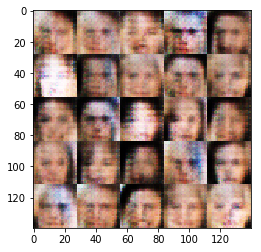

Epoch 1/1... Discriminator Loss: 1.2374... Generator Loss: 0.6879
Epoch 1/1... Discriminator Loss: 0.9302... Generator Loss: 2.5473
Epoch 1/1... Discriminator Loss: 0.8786... Generator Loss: 1.2374
Epoch 1/1... Discriminator Loss: 0.8773... Generator Loss: 1.2966
Epoch 1/1... Discriminator Loss: 1.2672... Generator Loss: 1.0638
Epoch 1/1... Discriminator Loss: 0.9538... Generator Loss: 1.2344
Epoch 1/1... Discriminator Loss: 0.8097... Generator Loss: 1.4095
Epoch 1/1... Discriminator Loss: 0.9976... Generator Loss: 1.1167
Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 1.0475
Epoch 1/1... Discriminator Loss: 2.0765... Generator Loss: 3.2881


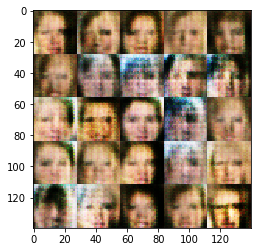

Epoch 1/1... Discriminator Loss: 1.1506... Generator Loss: 1.2800
Epoch 1/1... Discriminator Loss: 1.2572... Generator Loss: 0.8070
Epoch 1/1... Discriminator Loss: 1.1309... Generator Loss: 1.0942
Epoch 1/1... Discriminator Loss: 1.2701... Generator Loss: 0.7053
Epoch 1/1... Discriminator Loss: 1.1786... Generator Loss: 0.8607
Epoch 1/1... Discriminator Loss: 0.9958... Generator Loss: 1.0925
Epoch 1/1... Discriminator Loss: 1.1310... Generator Loss: 1.3502
Epoch 1/1... Discriminator Loss: 0.9749... Generator Loss: 1.0443
Epoch 1/1... Discriminator Loss: 1.1618... Generator Loss: 0.7091
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.9124


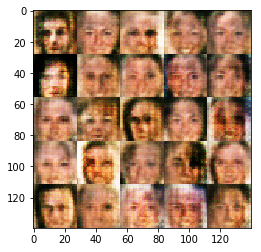

Epoch 1/1... Discriminator Loss: 1.1441... Generator Loss: 1.1382
Epoch 1/1... Discriminator Loss: 1.1694... Generator Loss: 1.9301
Epoch 1/1... Discriminator Loss: 1.2818... Generator Loss: 0.6547
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.5579
Epoch 1/1... Discriminator Loss: 1.0259... Generator Loss: 0.9548
Epoch 1/1... Discriminator Loss: 1.0890... Generator Loss: 1.1883
Epoch 1/1... Discriminator Loss: 1.3052... Generator Loss: 0.7151
Epoch 1/1... Discriminator Loss: 1.2267... Generator Loss: 1.1786
Epoch 1/1... Discriminator Loss: 0.9532... Generator Loss: 1.3441
Epoch 1/1... Discriminator Loss: 1.1449... Generator Loss: 0.9076


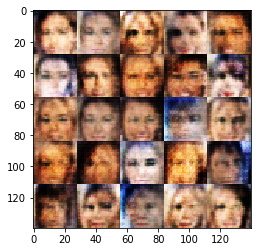

Epoch 1/1... Discriminator Loss: 1.0006... Generator Loss: 1.3502
Epoch 1/1... Discriminator Loss: 1.2535... Generator Loss: 0.7569
Epoch 1/1... Discriminator Loss: 1.1136... Generator Loss: 1.2562
Epoch 1/1... Discriminator Loss: 1.4707... Generator Loss: 1.5277
Epoch 1/1... Discriminator Loss: 1.1400... Generator Loss: 1.2539
Epoch 1/1... Discriminator Loss: 1.2570... Generator Loss: 1.8448
Epoch 1/1... Discriminator Loss: 1.2045... Generator Loss: 1.5366
Epoch 1/1... Discriminator Loss: 1.0862... Generator Loss: 1.3920
Epoch 1/1... Discriminator Loss: 1.2172... Generator Loss: 0.9237


In [25]:
batch_size = 256
z_dim = 200
learning_rate = 0.0008
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.